# Regresja liniowa: nadmierne dopasowanie i regularyzacja

W tym zadaniu zobaczymy, jak modele liniowe przetrenowują się, zrozumiemy, dlaczego tak się dzieje i dowiemy się, jak diagnozować i kontrolować przetrenowanie.

We wszystkich komórkach, w których znajduje się komentarz z instrukcjami, należy napisać kod wykonujący te instrukcje. Pozostałe komórki z kodem (bez komentarzy) należy po prostu wykonać. Ponadto zadanie wymaga udzielenia odpowiedzi na pytania; odpowiedzi należy wpisać po wyróżnionym słowie "__Answer:__".

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Będziemy pracować ze zbiorem danych "bikes_rent.csv", który zawiera informacje kalendarzowe i warunki pogodowe, które charakteryzują zautomatyzowane punkty wypożyczania rowerów, a także liczbę wypożyczeń w danym dniu. Te ostatnie będziemy przewidywać; w ten sposób rozwiążemy problem regresji.

## Zapoznanie się z danymi

## Zadanie 1

Załaduj zestaw danych za pomocą funkcji __pandas.read_csv__ do zmiennej __df__. Wydrukuj pierwsze 5 wierszy, aby upewnić się, że dane zostały poprawnie odczytane:

In [2]:
df = pd.read_csv("bikes_rent.csv") # put your code here
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Dla każdego dnia roboczego znane są następujące atrybuty:
* _season_: 1 - wiosna, 2 - lato, 3 - jesień, 4 - zima.
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: od 1 do 12.
* _holiday_: 0 - brak wakacji, 1 - wakacje.
* _weekday_: 0 do 6
* _workingday_: 0 oznacza dzień wolny od pracy, 1 oznacza dzień roboczy.
* _weathersit_: ocena korzystnej pogody od 1 (czysty, pogodny dzień) do 4 (ulewny deszcz, mgła)
* _temp_: temperatura w stopniach Celsjusza.
* _atemp_: temperatura w stopniach Celsjusza.
* _hum_: wilgotność
* _windspeed(mph)_: prędkość wiatru w milach na godzinę.
* _windspeed(ms)_: prędkość wiatru w metrach na sekundę.
* _cnt_: liczba wypożyczonych rowerów (jest to atrybut docelowy, będziemy go przewidywać).

Mamy więc cechy rzeczywiste, binarne i nominalne (porządkowe), a wszystkie z nich można traktować jako cechy rzeczywiste. Atrybuty nominalne mogą być również traktowane jako rzeczywiste, ponieważ mają porządek. Zobaczmy na wykresach, jak cecha docelowa zależy od innych cech

Wykres zależności atrybutów od liczby przejazdów. Innymi słowy, należy zbudować 12 wykresów. Każdy z nich powinien pokazywać zależność kolejnego atrybutu od zmiennej **cnt**. 

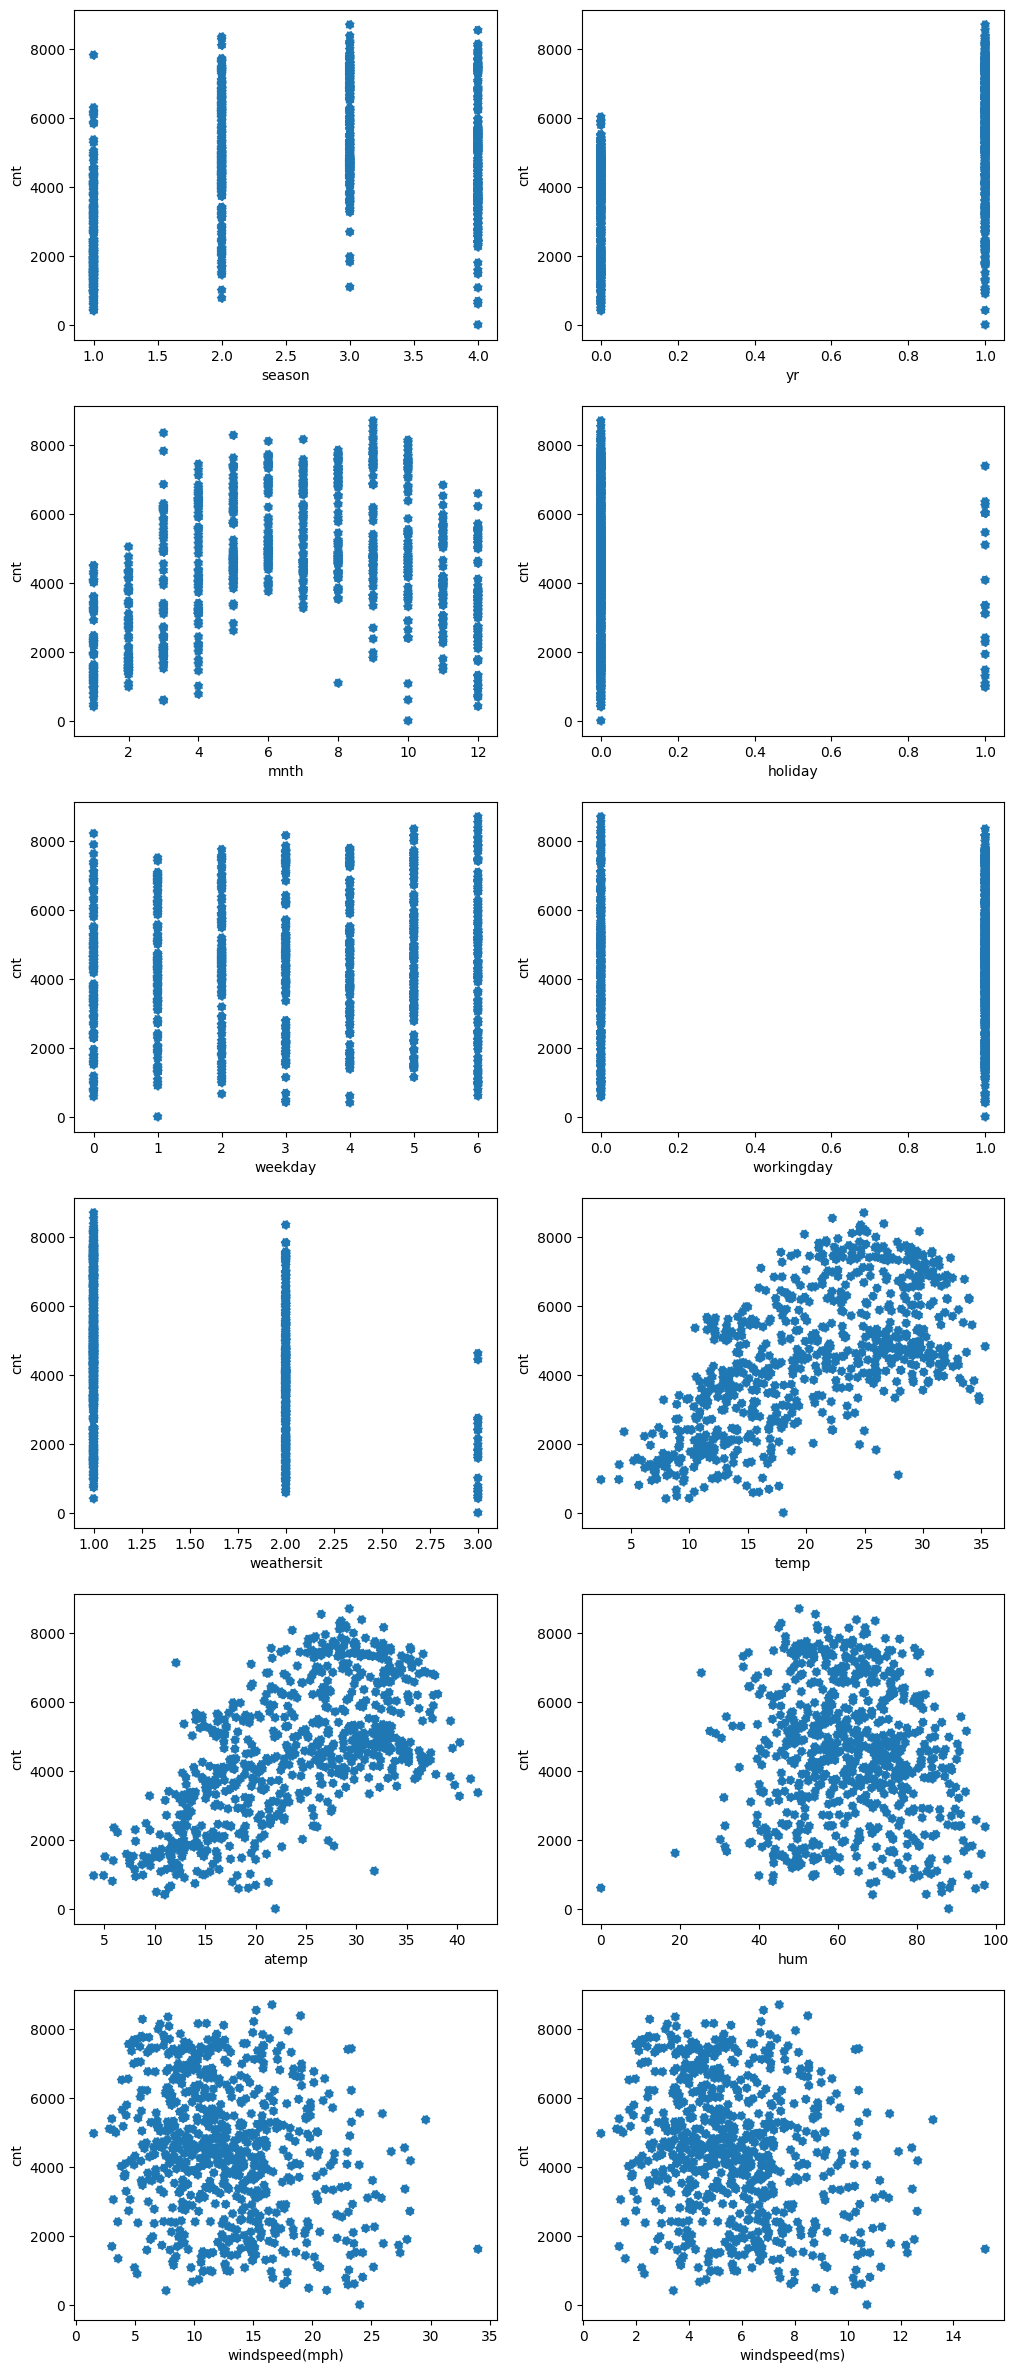

In [3]:
fig, axs = plt.subplots(6,2,figsize=(12, 30))
axs = axs.flatten()
for ind, column in enumerate(df.columns[:-1]):
    axs[ind].scatter(df[column],df["cnt"],label=column,linestyle=":")
    axs[ind].set_xlabel(column)  # Setting x-axis label
    axs[ind].set_ylabel('cnt')  # Setting y-axis label

<Axes: xlabel='mnth', ylabel='cnt'>

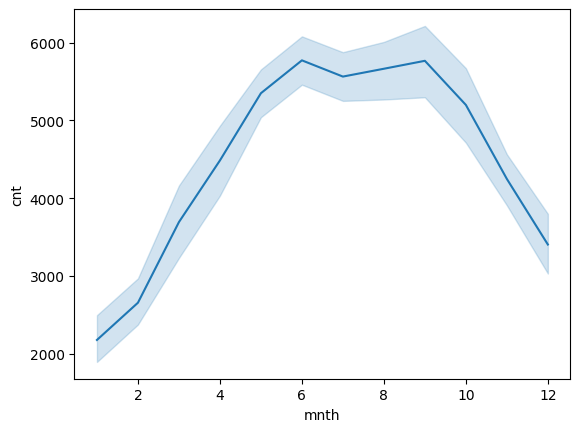

In [4]:
sns.lineplot(x="mnth", y="cnt", data=df)

__Pytania:__
1. Jaka jest natura zależności liczby wypożyczeń od miesiąca?
1. Podaj jedną lub dwie cechy, od których liczba wypożyczeń najprawdopodobniej zależy liniowo

Answer 1: W pierwszej połowie roku rośnie, przez wakacje jest względnie stała, a od września zaczyna spadać. A zatem nie jest liniowa.

Answer 2: **cnt** zależy liniowo od zmiennej **temp** oraz **atemp**. Przy czym obie zmienne są opisane jako temperatura w stopniach Celsjusza, ciekawe czego!

## Zadanie 2

Bardziej rygorystycznie oceńmy poziom zależności liniowej między cechami a zmienną docelową. Dobrą miarą zależności liniowej między dwoma wektorami jest korelacja Pearsona. Mieliśmy już z nią do czynienia wcześniej. Aby ją obliczyć w pandach, możemy skorzystać z metod dataframe: corr i corrwith.

Oblicz korelacje wszystkich cech oprócz ostatniej z ostatnią cechą za pomocą metody `corrwith`.

In [5]:
corr_mat = df.corr()# Obliczam cała macierz korelacji
print("Pearson correlation coeficient between 'cnt' and all atributes")
print(corr_mat[:-1]["cnt"])

Pearson correlation coeficient between 'cnt' and all atributes
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
Name: cnt, dtype: float64




```
# Wybrany format kodu
```

Istnieją cechy w próbce, które korelują z cechą docelową, co oznacza, że problem można rozwiązać za pomocą metod liniowych.

Z wykresów widzimy, że niektóre cechy są do siebie podobne. Obliczmy więc również korelacje między rzeczywistymi atrybutami.

## Zadanie 3

Oblicz korelacje parami między cechami temp, atemp, hum, windspeed(mph), windspeed(ms) i cnt
przy użyciu metody corr:

In [6]:
corr_mat.loc[["temp","atemp","hum","windspeed(mph)","windspeed(ms)","cnt"],["temp","atemp","hum","windspeed(mph)","windspeed(ms)","cnt"]] # Put your code here

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


Na przekątnych, tak jak powinno być, znajdują się jednostki. Jednak w macierzy znajdują się jeszcze dwie pary silnie skorelowanych kolumn: temp i atemp (skorelowane z natury) oraz dwie prędkości wiatru (ponieważ jest to tylko tłumaczenie niektórych jednostek na inne). Dalej zobaczymy, że fakt ten negatywnie wpływa na uczenie modelu liniowego.

Na koniec przyjrzyjmy się średniej cech (metoda średniej), aby oszacować skalę cech i ułamek 1 w cechach binarnych.

## Zadanie 4

Wyznacz średnią cech

In [7]:
# Put your code here
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Atrybuty mają różne skale, więc do dalszej pracy lepiej znormalizujemy macierz obiekt-atrybut.

### Problem pierwszy: cechy współliniowe

Tak więc w naszych danych jedna cecha duplikuje inną cechę i istnieją jeszcze dwie bardzo podobne cechy. Oczywiście moglibyśmy od razu usunąć duplikaty, ale zobaczmy, jak wyglądałby trening modelu, gdybyśmy nie zauważyli tego problemu.

Po pierwsze, wykonajmy skalowanie lub standaryzację cech: od każdej cechy odejmiemy jej średnią i podzielimy ją przez jej odchylenie standardowe. Można to zrobić za pomocą metody skalowania.

Ponadto musimy wymieszać próbkę do walidacji krzyżowej.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Przetrenujmy regresję liniową na naszych danych i przyjrzyjmy się wagom cech.

In [10]:
from sklearn.linear_model import LinearRegression

## Zadanie 5

Utwórz obiekt regresora liniowego, wytrenuj go na wszystkich danych i wyprowadź wagi modelu (wagi są przechowywane w zmiennej `coef_` klasy regresora). Możesz wyprowadzić pary (nazwa funkcji, waga) za pomocą funkcji `zip` wbudowanej w język Python. Nazwy cech są przechowywane w zmiennej `df.columns`.


In [11]:
regress = LinearRegression().fit(X,y) # Put your code here
for name, value in zip(df.columns, regress.coef_):
    print(f"{name:<20} = {value:^10}")

season               = 570.8637960129914
yr                   = 1021.9653779400622
mnth                 = -141.3017451148728
holiday              = -86.7593446245368
weekday              = 137.22506441350538
workingday           = 56.391881775973005
weathersit           = -330.2264620440312
temp                 = 367.48373260182126
atemp                = 585.5493861188597
hum                  = -145.61430569885857
windspeed(mph)       = 12457138390688.885
windspeed(ms)        = -12457138390887.346


Widzimy, że wagi dla cech zależnych liniowo są modulo znacznie większe niż dla innych cech. Aby zrozumieć, dlaczego tak się dzieje, przypomnijmy wzór analityczny używany do obliczania wag modelu liniowego w metodzie najmniejszych kwadratów:

$$w = (X^TX)^{-1} X^T y$$.

Jeśli $X$ ma współliniowe (liniowo zależne) kolumny, macierz $X^TX$ staje się zdegenerowana, a wzór nie jest już poprawny. Im bardziej zależne są cechy, tym mniejszy jest wyznacznik tej macierzy i tym gorsze przybliżenie $Xw \approx y$. Sytuacja ta nazywana jest _problemem wieloliniowości_.

Nie stało się tak w przypadku pary (temp, atemp) nieco mniej skorelowanych zmiennych, ale w praktyce zawsze warto uważnie obserwować współczynniki pod kątem podobnych znaków.

Aby rozwiązać problem wieloliniowości, musimy użyć regularyzatora. Do optymalizowanej funkcji dodaje się $L_1$ lub $L_2$ normę wag pomnożoną przez współczynnik regularyzacji $\alpha$. W pierwszym przypadku metoda nazywana jest Lasso, a w drugim --- Ridge

### Zadanie 6
Spróbujmy wytrenować modele liniowe z regularyzacją $L_1$ i $L_2$, a następnie porównajmy ich wagi. Wytrenuj regresory Ridge i Lasso z domyślnymi parametrami i zobacz, że problem z wagami został rozwiązany.

Wytrenować model liniowy z $L_1$-regularizacją (klasa Lasso) i wyprowadzić wagi

In [23]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X, y)
for name, value in zip(df.columns, lasso_reg.coef_):
    print(f"{name:<20} = {value:^10}")

season               = 560.2416160308861
yr                   = 1019.4634940657196
mnth                 = -128.73062703678696
holiday              = -86.15278133371106
weekday              = 137.34789390496314
workingday           = 55.21237064135668
weathersit           = -332.3698569623487
temp                 = 376.3632362096943
atemp                = 576.530793504555
hum                  = -144.12915500348583
windspeed(mph)       = -197.1396894024843
windspeed(ms)        = -2.8051404183533485e-08


Wytrenować model liniowy z $L_2$-regularizacją (klasa Ridge) i wyprowadzić wagi

In [13]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X, y)
for name, value in zip(df.columns, ridge_reg.coef_):
    print(f"{name:<20} = {value:^10}")

season               = 563.0645722520181
yr                   = 1018.9483787875305
mnth                 = -131.87332028247715
holiday              = -86.74609799709232
weekday              = 138.00511117871918
workingday           = 55.90311037506467
weathersit           = -332.34978849907367
temp                 = 386.45788919190807
atemp                = 566.3470470600669
hum                  = -145.07132729867195
windspeed(mph)       = -99.25944108179067
windspeed(ms)        = -99.25944115434177


### Zadanie 7

W przeciwieństwie do regularyzacji $L_2$, $L_1$ zeruje wagi dla niektórych cech. Zaobserwujmy, jak zmieniają się wagi wraz ze wzrostem współczynnika regularyzacji $\alpha$.

Dla każdej wartości współczynnika z `alphas`, wytrenuj regresor `Lasso` i zapisz wagi do listy `coefs_lasso`, a następnie wytrenuj `Ridge` i zapisz wagi do listy `coefs_ridge`. Przekonwertuj wynikowe listy na `np.array`.

In [14]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_reg = Lasso(alpha=alpha)
    lasso_reg.fit(X, y)
    coefs_lasso.append(lasso_reg.coef_)
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(X, y)
    coefs_ridge.append(ridge_reg.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Przeanalizuj dynamikę wag w miarę zwiększania parametru regularyzacji:

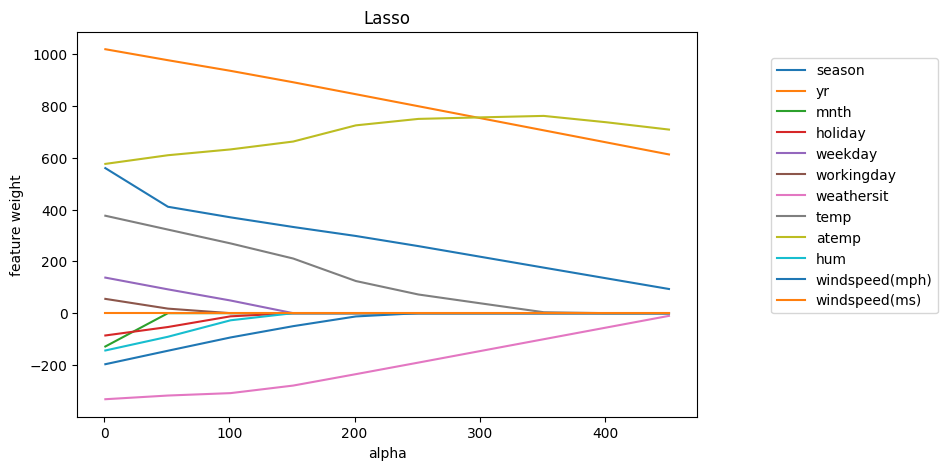

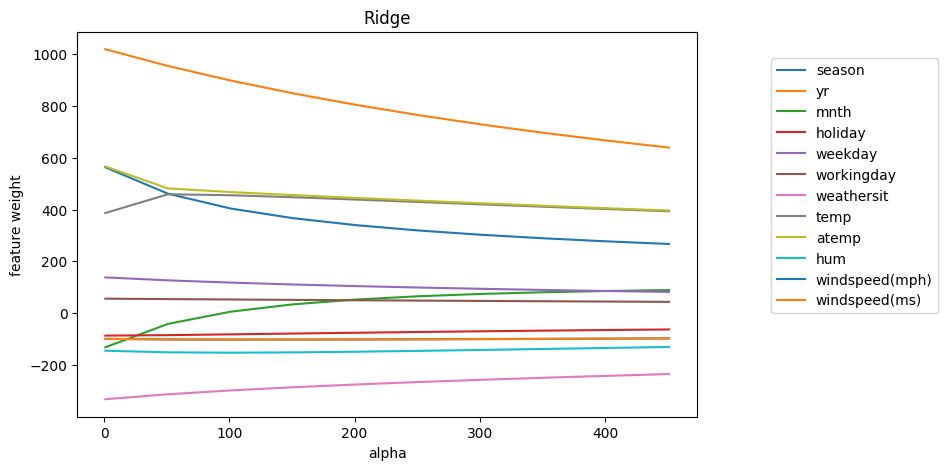

In [15]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature)

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature)

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Przeanalizuj wykresy i odpowiedz na poniższe pytania.

1. Który regularyzator (Ridge czy Lasso) bardziej agresywnie redukuje wagi dla tej samej wartości alfa?
2. Co dzieje się z wagami Lasso, jeśli wartość alfa jest bardzo duża? Wyjaśnij, dlaczego tak się dzieje.
3. Czy można argumentować, że `Lasso` eliminuje jedną z cech `prędkość wiatru` dla dowolnej wartości `alfa > 0`? A Ridge? Mówi się, że regularyzator wyklucza cechę, jeśli współczynnik dla niej jest mniejszy niż $10^{-3}$.
4. Który regularyzator jest odpowiedni do wybierania nieinformatywnych cech?

Answer 1: Lasso; np. dla alpha 1 kasuje od razu windspeed(ms), ridge nie kasuje nic; dla alpha 200 Lasso zostawił 5 cech, a ridge nie skasował żadnej

Answer 2: Gdy alpha jest duża wagi większości cech są równe 0 (niezerowe zostają tylko 3)

Answer 3: Tak, Lasso eleminuje **windspedd(ms)** dla dowolnej alphy (przetestowałem dla alpha = 0.0001). Ridge nie eleminuje tej cechy dla żadnej alphy

Answer 4: Lasso jest odpowiedni do usuwania nieinformatywnych cech

### Zadanie 8

Następnie będziemy pracować z `Lasso'.

Widzimy więc, że gdy zmieniamy alfa, model inaczej dopasowuje współczynniki cech. Musimy wybrać najlepszą wartość alfa.

W tym celu potrzebujemy przede wszystkim metryki jakości. Jako metryki użyjemy samej zoptymalizowanej funkcji najmniejszych kwadratów, tj. błędu średniokwadratowego.

Po drugie, musimy zrozumieć, na jakich danych obliczyć tę metrykę. Nie możemy wybrać "alfa" na podstawie wartości MSE na próbce treningowej, ponieważ wtedy nie możemy ocenić, w jaki sposób model będzie przewidywał na nowych danych. Jeśli wybierzemy jedną próbkę podzieloną między próbkę treningową i testową (nazywa się to wstrzymaniem), dostroimy się do konkretnych "nowych" danych i możemy ponownie przetrenować. Dlatego wykonamy kilka podziałów próbek, wypróbujemy różne wartości alfa dla każdej z nich, a następnie uśrednimy MSE. Wygodniej jest dokonać takich podziałów za pomocą walidacji krzyżowej, tj. podzielić próbkę na części $K$ i za każdym razem wziąć jedną z nich jako testową, a z pozostałych bloków utworzyć próbkę szkoleniową.

Przeprowadzenie walidacji krzyżowej dla regresji w sklearn jest dość proste: istnieje specjalny regresor do tego celu, __LassoCV__, który pobiera jako dane wejściowe listę alfa i dla każdego z nich oblicza MSE na walidacji krzyżowej. Po treningu (jeśli pozostawimy domyślny parametr cv=3), regresor będzie zawierał zmienną __mse\_path\___, macierz o rozmiarze len(alpha) x k, k = 3 (liczba bloków w walidacji krzyżowej), zawierającą wartości MSE na teście dla odpowiednich przebiegów. Ponadto zmienna alpha\_ będzie przechowywać wybraną wartość parametru regularyzacji, a coef\_ będzie tradycyjnie przechowywać wytrenowane wagi odpowiadające tej alpha_.

Należy pamiętać, że regresor może zmienić kolejność, w jakiej działa na alphas; lepiej jest użyć zmiennej regresora alphas_, aby dopasować ją do macierzy MSE.

Wytrenuj regresor `LassoCV` na wszystkich parametrach regularyzacji od alfa. Wykreśl linie _averaged_ over `MSE` jako funkcję `alpha` (w tym celu użyj funkcji `create_plot`).

Wyprowadź wybraną wartość `alpha`, jak również pary cecha-współczynnik dla wytrenowanego wektora współczynników.

In [16]:
def create_plot(x, y, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    plt.plot(x, y, marker="o")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [17]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)
regressor = LassoCV(alphas=alphas, cv = 3).fit(X,y)



In [18]:
print(f"Lasso - best alpha: {regressor.alpha_}")
for name, value in zip(df.columns, regressor.coef_):
    print(f"{name:<20} = {value:^10}")

Lasso - best alpha: 6
season               = 532.0189828413535
yr                   = 1015.0602226430595
mnth                 = -100.03952614356629
holiday              = -83.29395987529904
weekday              = 132.50446549095795
workingday           = 51.557085614073735
weathersit           = -330.5598567399817
temp                 = 370.67985503003405
atemp                = 581.396931065498
hum                  = -140.00740550068844
windspeed(mph)       = -191.77140847135036
windspeed(ms)        = -2.6854702314758792e-08


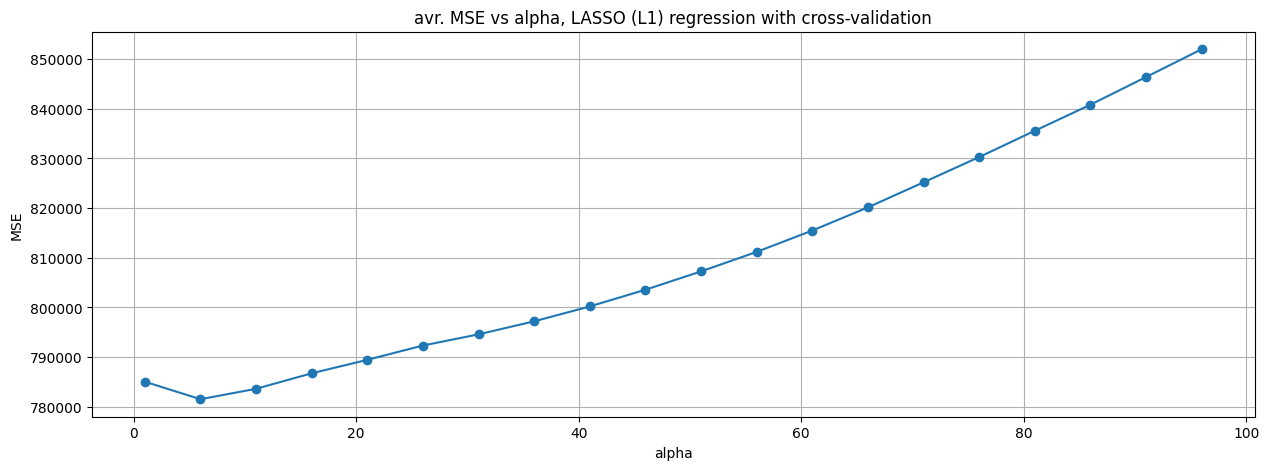

In [19]:
create_plot(regressor.alphas_, regressor.mse_path_.mean(axis=1),title="avr. MSE vs alpha, LASSO (L1) regression with cross-validation",xlabel="alpha", ylabel="MSE")

Wybraliśmy więc pewien parametr regularyzacji. Zobaczmy, jaki parametr alfa wybralibyśmy, gdybyśmy podzielili próbkę tylko raz na trening i test, tj. rozważyli trajektorie MSE odpowiadające oddzielnym blokom próbki.

### Zadanie 9

Wyprowadź wartości `alpha` odpowiadające minimom `MSE` na każdej partycji (tj. według kolumn).
Wizualizacja kolumn `mse_path_` na trzech oddzielnych wykresach.


[18 19  9]
Best alpha: 6     , MSE: 733725.7604052249
Best alpha: 1     , MSE: 799433.1673691692
Best alpha: 51    , MSE: 796979.8955193626


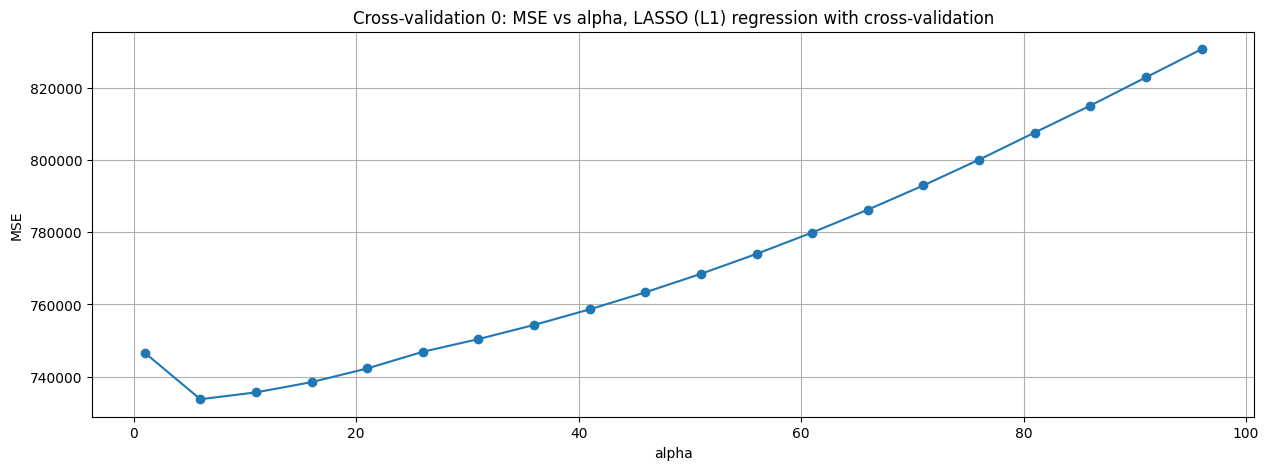

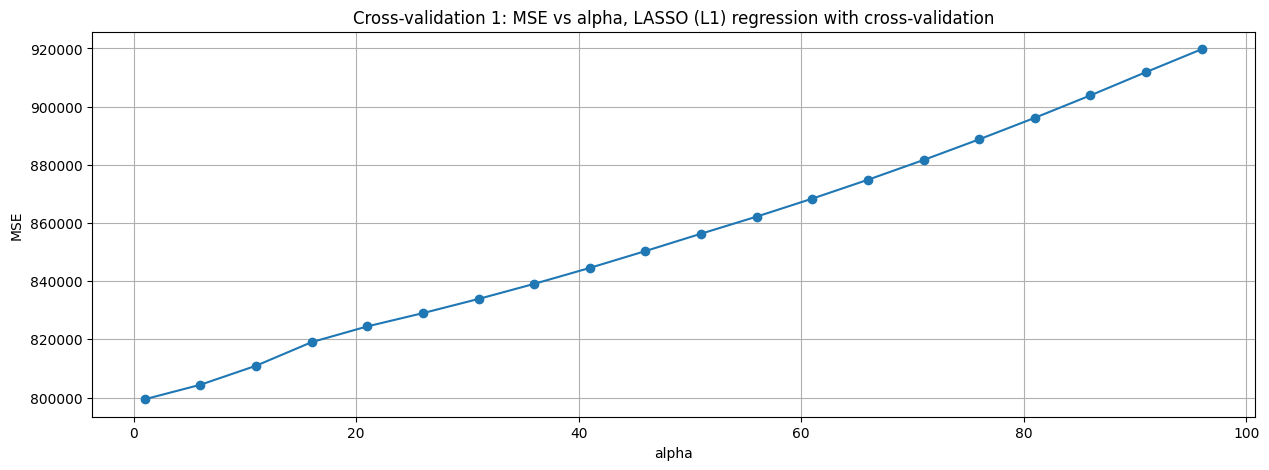

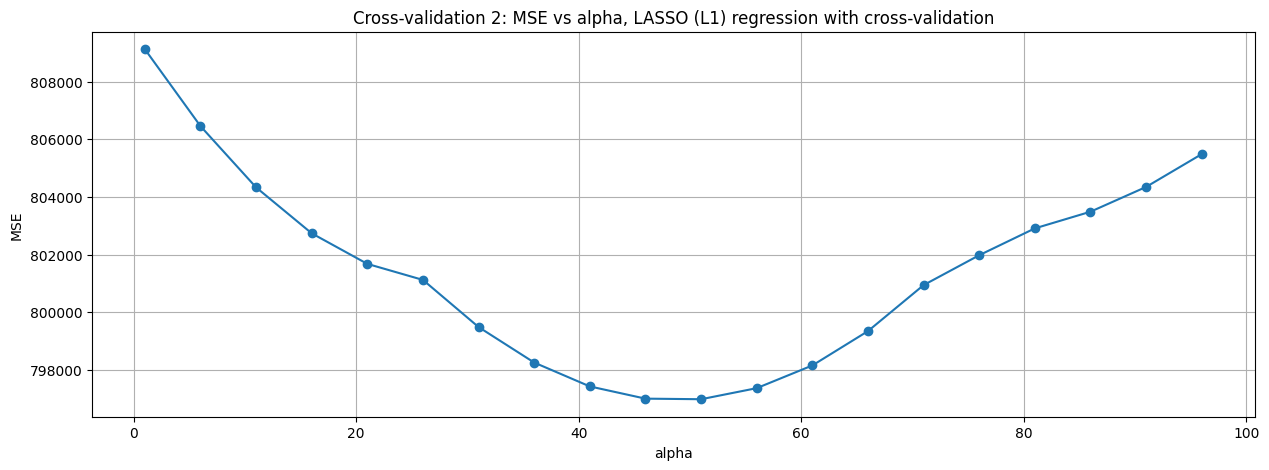

In [20]:
mse_min_ind = np.argmin(regressor.mse_path_, axis=0) # find indices of minimal MSE values in each column
print(mse_min_ind)
for count, mse_ind in enumerate(mse_min_ind):
    print(f"Best alpha: {regressor.alphas_[mse_ind]:<6}, MSE: {regressor.mse_path_[mse_ind,count]:<10}")

for n in range(3):
   create_plot(regressor.alphas_, regressor.mse_path_[:,n],title=f"Cross-validation {n}: MSE vs alpha, LASSO (L1) regression with cross-validation",xlabel="alpha", ylabel="MSE")

W każdej partycji optymalna wartość "alfa" jest inna i odpowiada dużemu MSE w innych partycjach. Okazuje się, że dostosowujemy się do konkretnych próbek treningowych i kontrolnych. Kiedy wybieramy `alpha` w walidacji krzyżowej, wybieramy coś "średniego", co da akceptowalną wartość metryki na różnych partycjach próbki.

### Zadanie 10

Na koniec, jak to zwykle bywa w analizie danych, zinterpretujmy wynik. Odpowiedz na następujące pytania.

#### Pytanie 1

W ostatnim wytrenowanym modelu wybierz 4 cechy o najwyższych (dodatnich) współczynnikach (i wypisz je), spójrz na wizualizacje zależności `cnt` od tych cech, które narysowaliśmy w bloku "Poznawanie danych". Czy na wykresach widać rosnącą liniową zależność `cnt` od tych cech? Czy logiczne jest twierdzenie (wynikające ze zdrowego rozsądku), że im większa wartość tych atrybutów, tym więcej osób będzie chciało wypożyczyć rowery?

__Odpowiedź:__

Lasso - best alpha: 6
season               = 532.0189828413535
yr                   = 1015.0602226430595
temp                 = 370.67985503003405
atemp                = 581.396931065498


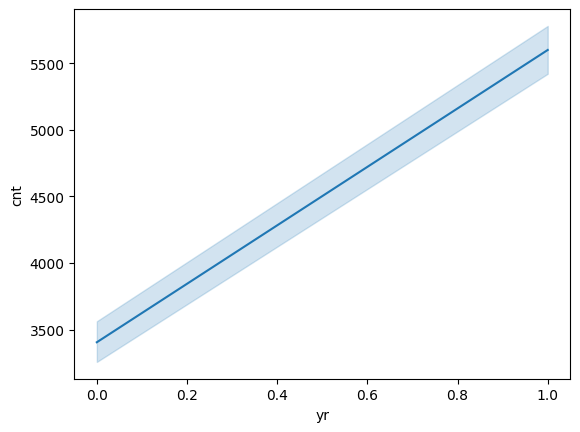

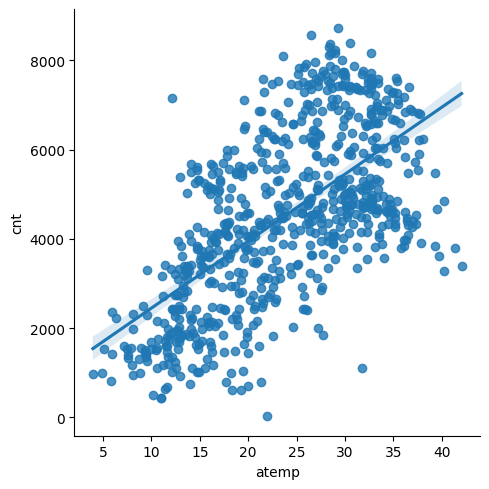

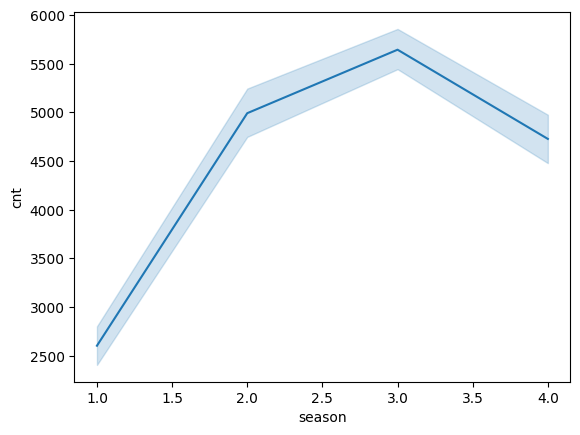

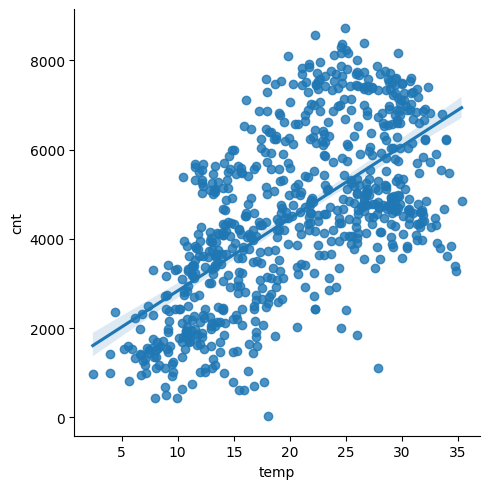

In [21]:
# TOP4 features
top4 = ["yr", "atemp", "season", "temp"]
print(f"Lasso - best alpha: {regressor.alpha_}")
for name, value in zip(df.columns, regressor.coef_):
    if name in top4:
        print(f"{name:<20} = {value:^10}")
# wykresy pomocnicze
sns.lineplot(x="yr", y="cnt", data=df)
plt.show()
sns.lmplot(x="atemp", y="cnt", data=df)
plt.show()
sns.lineplot(x="season", y="cnt", data=df)
plt.show()
sns.lmplot(x="temp", y="cnt", data=df)
plt.show()

Odpowiedź: Cechy **yr** (rok), **temp** i **atemp** są z pewnością skorelowane dodatnio z liczbą wypożyczonych rowerów. Co do pory roku **season** liniowa zależność nie do końca jest prawdziwa. Obserwujemy w dobrym przyblizeniu liniowy wzrost **cnt** do wiosny do jesieni, a potem spadek w zimie (co ma sens).

#### Pytanie 2

Wybierz 3 cechy o największych współczynnikach modulo ujemnych (i wypisz je), spójrz na odpowiednie wizualizacje. Czy widoczna jest malejąca zależność liniowa? Czy logiczne jest stwierdzenie, że im większa wielkość tych cech, tym mniej osób będzie chciało wsiąść na rower?

__Odpowiedź:__

Lasso - best alpha: 6
weathersit           = -330.5598567399817
hum                  = -140.00740550068844
windspeed(mph)       = -191.77140847135036


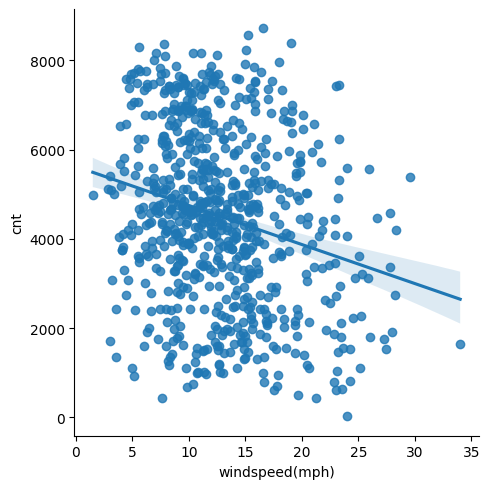

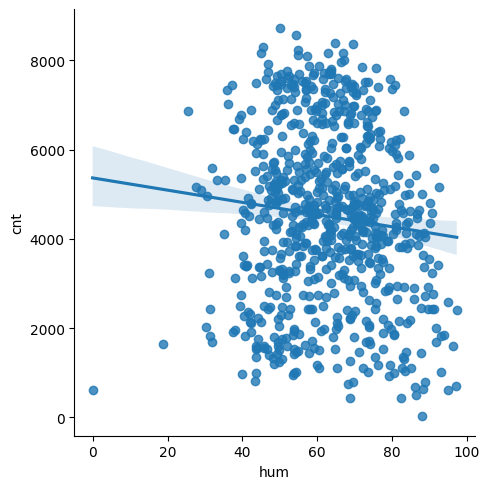

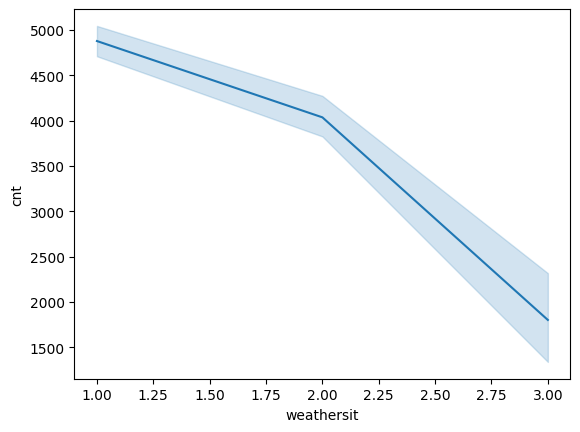

In [22]:
top3 = ["windspeed(mph)", "weathersit", "hum"]
print(f"Lasso - best alpha: {regressor.alpha_}")
for name, value in zip(df.columns, regressor.coef_):
    if name in top3:
        print(f"{name:<20} = {value:^10}")
# wykresy pomocnicze
sns.lmplot(x="windspeed(mph)", y="cnt", data=df)
plt.show()
sns.lmplot(x="hum", y="cnt", data=df)
plt.show()
sns.lineplot(x="weathersit", y="cnt", data=df)
plt.show()

Odpowiedź: Liczba wypożyczonych rowerów jest ujemnie skorelowana z **windspeed(mph)** oraz **weathersit**, co ma sens. Im gorsza ocena pogody (wyższa wartość **weathersit**) oraz mocniejszy wiatr tym mniej osób ma chęć wsiąść na rower. Co do wilgotności **hum** to tendencja jest podobna, ale tutaj korelacja jest słabsza i grzej widać trend w danych.

#### Pytanie 3

Wypisz znaki ze współczynnikami bliskimi zeru (< 1e-3). Jak myślisz, dlaczego model wykluczył je z modelu (spójrz ponownie na wykresy)? Czy to prawda, że nie mają one wpływu na popyt na rowery?

__Odpowiedź:__

Zerowa waga jest dla cechy **windspeed(ms)**. Jest to cecha redundanta (liniowo zależna) w stosunku do **windspeed(mph)** (prędkość wiatru wyrażona w innej jednostce) i została wyzerowana w wyniku zastosowanej regularyzacji L1, bo nie wnosi jako tako nowej informacji do modelu. Jednakże nie oznacza to, że **cnt** nie zależy od **windspeed(ms)**. **cnt** maleje, gdy **windspeed(ms)** rośnie, jednakże ta zależność została uwzględniona w modelu poprzez cechę **windspeed(mph)**. 

### Wnioski
Widzieliśmy więc, jak monitorować adekwatność modelu liniowego, jak wybierać cechy i jak prawidłowo wybrać współczynnik regularyzacji, jeśli to możliwe bez dostosowywania się do określonej części danych.

Warto zauważyć, że wygodnie jest wybrać tylko niewielką liczbę parametrów (1, 2, maksymalnie 3) za pomocą walidacji krzyżowej, ponieważ dla każdej dopuszczalnej kombinacji parametrów musimy trenować model kilka razy. Proces ten zajmuje dużo czasu, zwłaszcza jeśli musimy trenować na dużych ilościach danych.